✓ torch_tensorrt imported successfully.
Primary benchmark device: cuda
✓ Found model file for 'baseline'
✓ Found model file for 'ptq_perchannel'
✓ Found model file for 'ptq_pertensor'
✓ Found model file for 'qat'
✓ Found model file for 'tensorrt_fp32'
✓ Found model file for 'tensorrt_fp16'
🚀 Starting Comprehensive Model Optimization Comparison

                  LOADING ALL MODELS
  -> Loading baseline model resnet50_baseline_ft_imagenetmini_final.pth...
✓ Registered job: Baseline (FP32) - CPU
✓ Registered job: Baseline (FP32) - GPU
  -> Loading JIT model model_final.pth...
✓ Loaded PTQ Per-Channel INT8
  -> Loading JIT model model_final.pth...
✓ Loaded PTQ Per-Tensor INT8
  -> Loading JIT model model_final.pth...
✓ Loaded QAT INT8
  -> Loading JIT model resnet50_trt_fp32.ts...
✓ Loaded TensorRT FP32
  -> Loading JIT model resnet50_trt_fp16.ts...
✓ Loaded TensorRT FP16

✅ Successfully loaded 7 benchmark jobs.

==================== RUNNING BENCHMARKS ====================
Benchmarking Ba

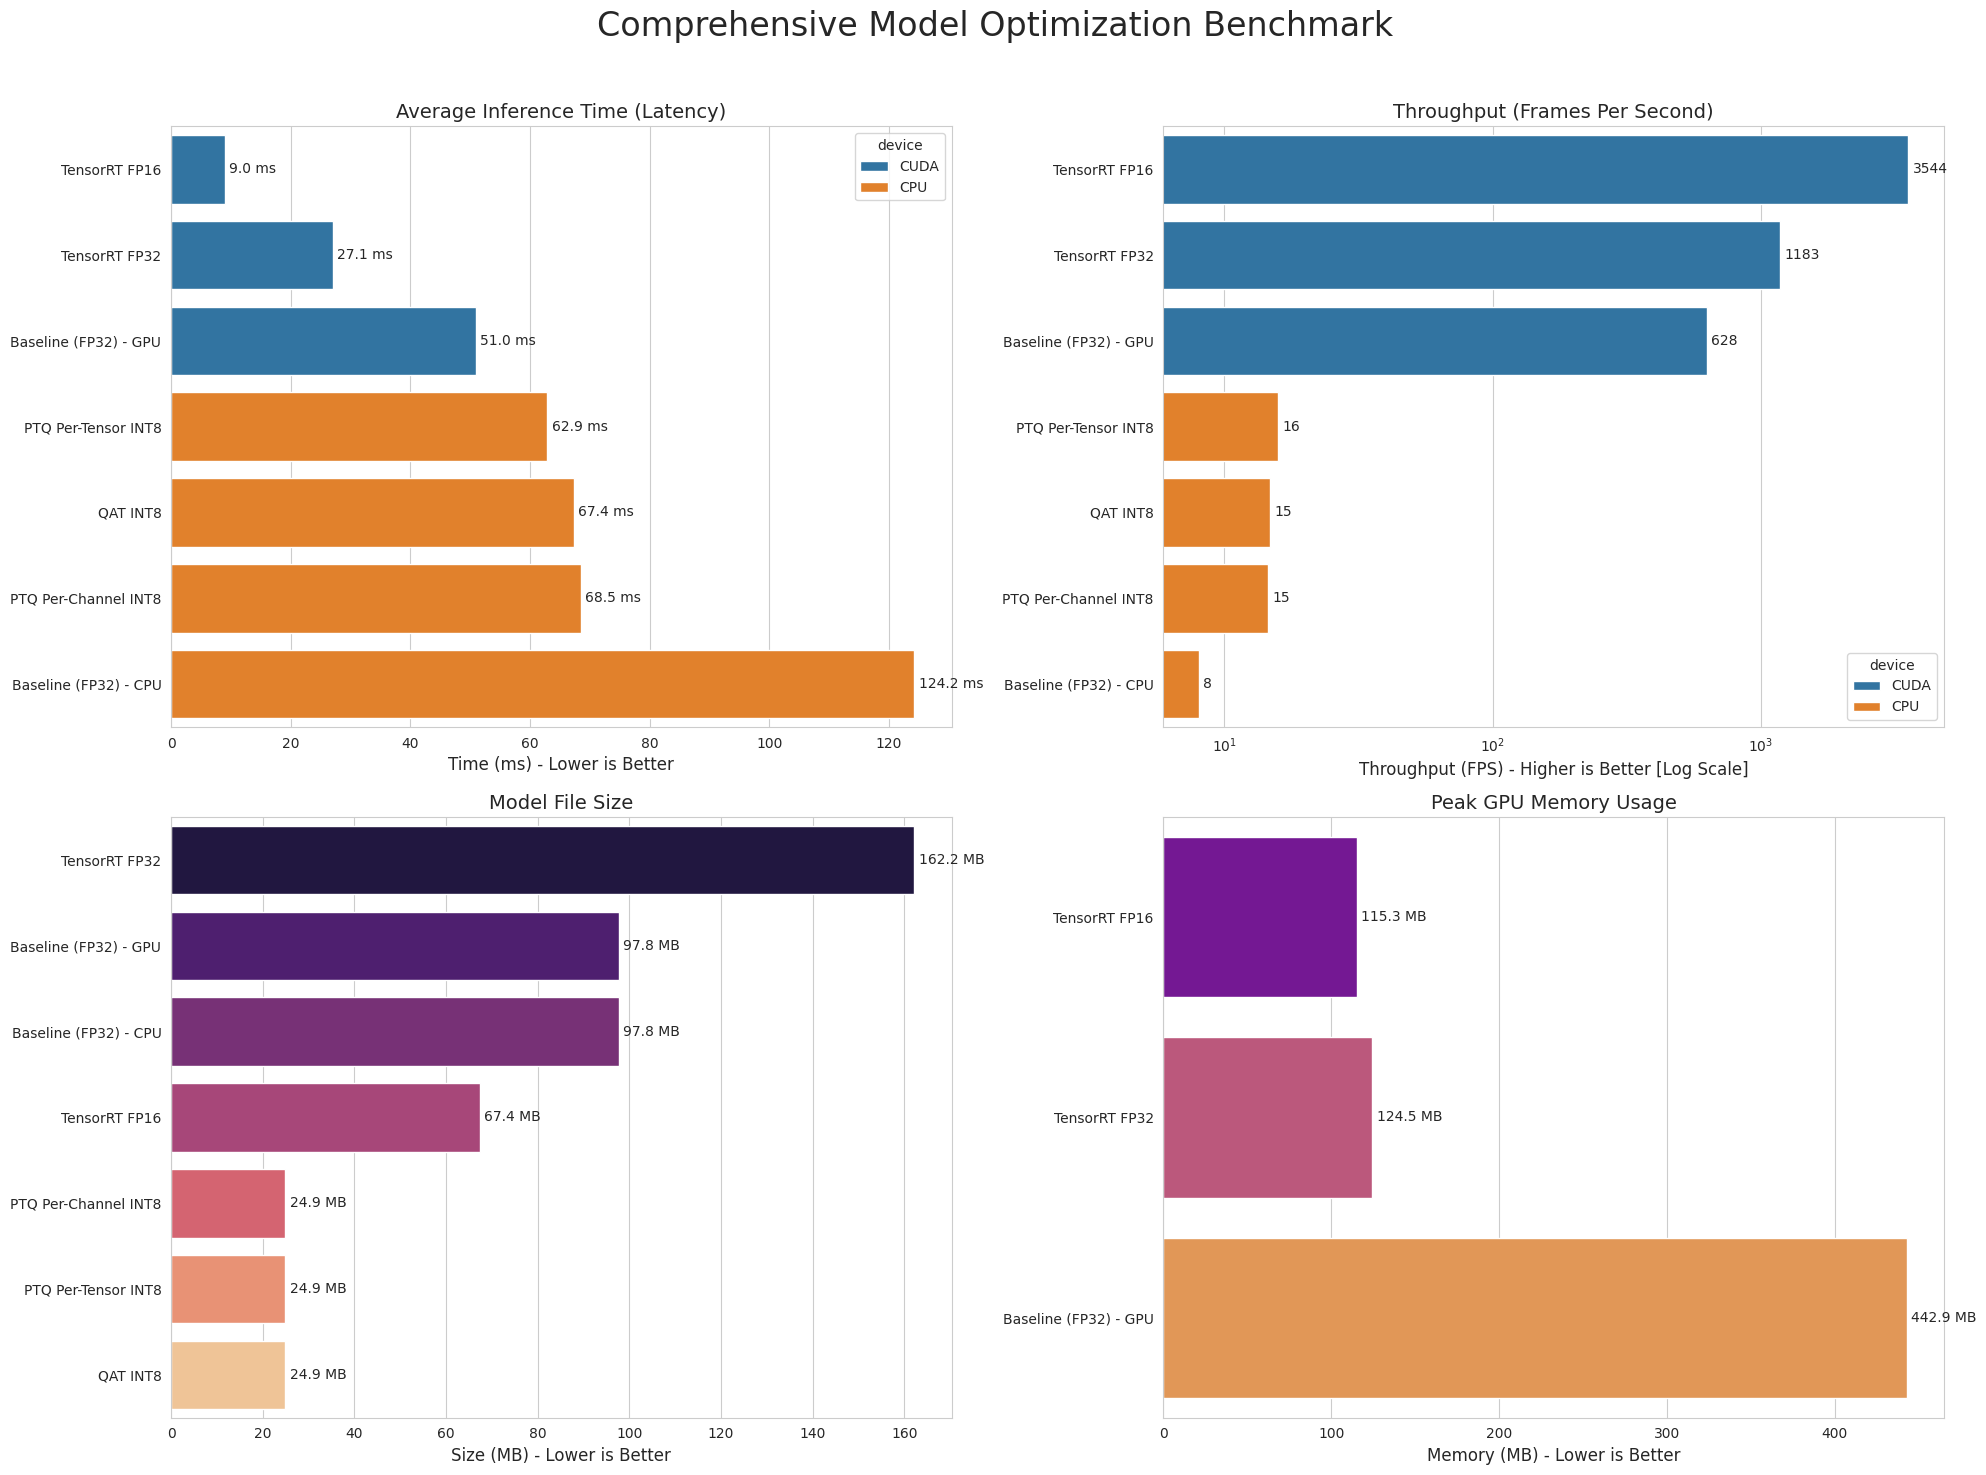


📋 COMPREHENSIVE OPTIMIZATION SUMMARY
                Model Device  Batch Size  Latency (ms)  Throughput (FPS)  Size (MB)  GPU Mem (MB)  Speedup vs GPU Baseline  Speedup vs CPU Baseline  Compression
        TensorRT FP16      -          32          9.03           3543.56      67.38        115.35                     5.65                    13.76         1.45
        TensorRT FP32      -          32         27.06           1182.61     162.20        124.53                     1.88                     4.59         0.60
Baseline (FP32) - GPU      -          32         50.99            627.62      97.80        442.91                     1.00                     2.44         1.00
  PTQ Per-Tensor INT8      -           1         62.91             15.90      24.94          0.00                     0.81                     1.98         3.92
             QAT INT8      -           1         67.38             14.84      24.94          0.00                     0.76                     1.84         3

In [1]:
# %%
# ===================================================================
#                      IMPORTS AND SETUP
# ===================================================================
import torch
import torch.nn as nn
import torchvision.models as models
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import gc

try:
    import torch_tensorrt
    print("✓ torch_tensorrt imported successfully.")
except ImportError:
    print("✗ WARNING: torch_tensorrt is not installed. TensorRT models will fail to load.")

sns.set_style("whitegrid")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Primary benchmark device: {DEVICE}")

# %%
# ===================================================================
#                           MODEL PATHS
# ===================================================================
CONTAINER_DATA_PATH = '/workspace'
MODEL_PATHS = {
    'baseline': os.path.join(CONTAINER_DATA_PATH, r'saved_models_and_logs/resnet50_baseline/resnet50_baseline_ft_imagenetmini_final.pth'),
    'ptq_perchannel': os.path.join(CONTAINER_DATA_PATH, r'saved_models_and_logs/quantization_ptq_int8/resnet50_quant_ptq_int8_perchannel_post/model_final.pth'),
    'ptq_pertensor': os.path.join(CONTAINER_DATA_PATH, r'saved_models_and_logs/quantization_ptq_int8/resnet50_quant_ptq_int8_pertensor_post/model_final.pth'),
    'qat': os.path.join(CONTAINER_DATA_PATH, r'saved_models_and_logs/quantization_qat_int8/resnet50_quant_qat_int8_epochs8/model_final.pth'),
    'tensorrt_fp32': os.path.join(CONTAINER_DATA_PATH, r'saved_models_and_logs/tensorrt/resnet50_trt_fp32.ts'),
    'tensorrt_fp16': os.path.join(CONTAINER_DATA_PATH, r'saved_models_and_logs/tensorrt/resnet50_trt_fp16.ts')
}
for name, path in MODEL_PATHS.items():
    if not os.path.exists(path): print(f"⚠️ WARNING: Path for '{name}' not found: {path}")
    else: print(f"✓ Found model file for '{name}'")

# %%
# ===================================================================
#                     BENCHMARKING CONFIGURATION
# ===================================================================
GPU_BATCH_SIZE = 32
CPU_BATCH_SIZE = 1

# %%
# ===================================================================
#                         MODEL LOADER CLASS
# ===================================================================
class ModelLoader:
    @staticmethod
    def load_baseline_model(path, num_classes=1000):
        print(f"  -> Loading baseline model {os.path.basename(path)}...")
        model = models.resnet50(weights=None); model.fc = nn.Linear(model.fc.in_features, num_classes)
        checkpoint = torch.load(path, map_location='cpu'); state_dict = checkpoint.get('model_state_dict', checkpoint)
        model.load_state_dict(state_dict)
        return model.eval()

    @staticmethod
    def load_jit_model(path):
        print(f"  -> Loading JIT model {os.path.basename(path)}...")
        return torch.jit.load(path, map_location='cpu').eval()

# %%
# ===================================================================
#                      BENCHMARKING UTILITIES
# ===================================================================
def get_file_size_mb(file_path):
    if os.path.exists(file_path): return os.path.getsize(file_path) / (1024 * 1024)
    return 0

def benchmark_model(model, input_tensor_cpu, target_device, num_runs=50, model_name="Model"):
    print(f"Benchmarking {model_name} on {str(target_device).upper()} with batch size {input_tensor_cpu.shape[0]}...")
    model.to(target_device); input_tensor = input_tensor_cpu.to(target_device)
    if 'FP16' in model_name: input_tensor = input_tensor.half()
    with torch.no_grad():
        for _ in range(20): _ = model(input_tensor)
        if target_device.type == 'cuda': torch.cuda.synchronize()
    if target_device.type == 'cuda': torch.cuda.reset_peak_memory_stats(target_device)
    times = []
    with torch.no_grad():
        for i in range(num_runs):
            if target_device.type == 'cuda':
                start_event = torch.cuda.Event(enable_timing=True); end_event = torch.cuda.Event(enable_timing=True)
                start_event.record()
            else: start_time = time.perf_counter()
            _ = model(input_tensor)
            if target_device.type == 'cuda':
                end_event.record(); torch.cuda.synchronize(target_device)
                times.append(start_event.elapsed_time(end_event))
            else:
                end_time = time.perf_counter(); times.append((end_time - start_time) * 1000)
    mem_used = torch.cuda.max_memory_allocated(target_device) / 1024**2 if target_device.type == 'cuda' else 0
    times = np.array(times)
    stats = {'mean': np.mean(times), 'std': np.std(times), 'throughput_fps': 1000 / np.mean(times) * input_tensor.shape[0], 'memory_mb': mem_used, 'device': str(target_device).upper(), 'batch_size': input_tensor.shape[0]}
    return stats

# %%
# ===================================================================
#                        MODEL LOADING LOGIC
# ===================================================================
def load_all_models():
    models_dict = OrderedDict(); model_info = OrderedDict()
    print("\n" + "="*50); print("                  LOADING ALL MODELS"); print("="*50)
    if os.path.exists(MODEL_PATHS['baseline']):
        baseline_model = ModelLoader.load_baseline_model(MODEL_PATHS['baseline'])
        baseline_info = {'type': 'PyTorch', 'precision': 'FP32', 'file_size_mb': get_file_size_mb(MODEL_PATHS['baseline'])}
        models_dict['Baseline (FP32) - CPU'] = baseline_model; model_info['Baseline (FP32) - CPU'] = baseline_info
        print("✓ Registered job: Baseline (FP32) - CPU")
        if DEVICE.type == 'cuda':
            models_dict['Baseline (FP32) - GPU'] = baseline_model; model_info['Baseline (FP32) - GPU'] = baseline_info
            print("✓ Registered job: Baseline (FP32) - GPU")
    quant_map = {'PTQ Per-Channel INT8': 'ptq_perchannel', 'PTQ Per-Tensor INT8': 'ptq_pertensor', 'QAT INT8': 'qat'}
    for name, key in quant_map.items():
        if os.path.exists(MODEL_PATHS[key]):
            models_dict[name] = ModelLoader.load_jit_model(MODEL_PATHS[key])
            model_info[name] = {'type': 'Quantized (JIT)', 'precision': 'INT8', 'file_size_mb': get_file_size_mb(MODEL_PATHS[key])}
            print(f"✓ Loaded {name}")
    trt_map = {'TensorRT FP32': 'tensorrt_fp32', 'TensorRT FP16': 'tensorrt_fp16'}
    if DEVICE.type == 'cuda':
        for name, key in trt_map.items():
            if os.path.exists(MODEL_PATHS[key]):
                models_dict[name] = ModelLoader.load_jit_model(MODEL_PATHS[key])
                model_info[name] = {'type': 'TensorRT', 'precision': 'FP32' if 'fp32' in key else 'FP16', 'file_size_mb': get_file_size_mb(MODEL_PATHS[key])}
                print(f"✓ Loaded {name}")
    return models_dict, model_info

# %%
# ===================================================================
#                   COMPREHENSIVE BENCHMARK RUNNER
# ===================================================================
def run_comprehensive_benchmark(models_dict, model_info):
    all_results = OrderedDict()
    print(f"\n{'='*20} RUNNING BENCHMARKS {'='*20}")
    for model_name, model in models_dict.items():
        if 'CPU' in model_name or 'INT8' in model_name:
            target_device = torch.device('cpu'); batch_size = CPU_BATCH_SIZE
        else:
            target_device = DEVICE; batch_size = GPU_BATCH_SIZE
        input_tensor_cpu = torch.randn(batch_size, 3, 224, 224)
        try:
            stats = benchmark_model(model, input_tensor_cpu, target_device, num_runs=50, model_name=model_name)
            if stats is not None:
                stats.update(model_info[model_name]); all_results[model_name] = stats
        except Exception as e:
            print(f"\nERROR: Benchmarking for {model_name} failed. Error: {e}")
        if DEVICE.type == 'cuda': torch.cuda.empty_cache()
        gc.collect()
    return all_results

# %%
# ===================================================================
#                       PLOTTING & REPORTING
# ===================================================================
def create_comprehensive_plots(all_results):
    plot_data = []; [entry.update({'Model': name}) for name, entry in all_results.items()]
    df = pd.DataFrame(list(all_results.values()))
    if df.empty: print("No data to plot."); return None
    df = df.sort_values('mean', ascending=True).reset_index(drop=True)
    fig, axes = plt.subplots(2, 2, figsize=(20, 15)); fig.suptitle('Comprehensive Model Optimization Benchmark', fontsize=24)
    ax1 = sns.barplot(data=df, x='mean', y='Model', hue='device', ax=axes[0, 0], dodge=False); ax1.set_title('Average Inference Time (Latency)', fontsize=14); ax1.set_xlabel("Time (ms) - Lower is Better", fontsize=12); ax1.set_ylabel(""); [ax1.bar_label(c, fmt='%.1f ms', padding=3) for c in ax1.containers]
    ax2 = sns.barplot(data=df, x='throughput_fps', y='Model', hue='device', ax=axes[0, 1], dodge=False); ax2.set_title('Throughput (Frames Per Second)', fontsize=14); ax2.set_xlabel("Throughput (FPS) - Higher is Better [Log Scale]", fontsize=12); ax2.set_ylabel(""); ax2.set_xscale('log'); [ax2.bar_label(c, fmt='%.0f', padding=3) for c in ax2.containers]
    
    # --- [THE FIX] --- Added hue='Model' and legend=False to fix warnings
    ax3 = sns.barplot(data=df.sort_values('file_size_mb', ascending=False), x='file_size_mb', y='Model', ax=axes[1, 0], palette='magma', hue='Model', legend=False); ax3.set_title('Model File Size', fontsize=14); ax3.set_xlabel("Size (MB) - Lower is Better", fontsize=12); ax3.set_ylabel(""); [ax3.bar_label(c, fmt='%.1f MB', padding=3) for c in ax3.containers]
    gpu_df = df[df['device'] == 'CUDA'].copy()
    if not gpu_df.empty:
        ax4 = sns.barplot(data=gpu_df, x='memory_mb', y='Model', ax=axes[1, 1], palette='plasma', hue='Model', legend=False); ax4.set_title('Peak GPU Memory Usage', fontsize=14); ax4.set_xlabel("Memory (MB) - Lower is Better", fontsize=12); ax4.set_ylabel(""); [ax4.bar_label(c, fmt='%.1f MB', padding=3) for c in ax4.containers]
    
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()
    return df

def create_summary_table(df):
    if df is None or df.empty: return None
    summary_data = df.copy()
    try:
        baseline_gpu_time = df[df['Model'] == 'Baseline (FP32) - GPU']['mean'].iloc[0]
        summary_data['Speedup vs GPU Baseline'] = baseline_gpu_time / summary_data['mean']
    except (IndexError, KeyError): summary_data['Speedup vs GPU Baseline'] = np.nan
    try:
        baseline_cpu_time = df[df['Model'] == 'Baseline (FP32) - CPU']['mean'].iloc[0]
        summary_data['Speedup vs CPU Baseline'] = baseline_cpu_time / summary_data['mean']
    except (IndexError, KeyError): summary_data['Speedup vs CPU Baseline'] = np.nan
    summary_data['Compression'] = df[df['Model'].str.contains('Baseline')]['file_size_mb'].max() / summary_data['file_size_mb']
    display_cols = ['Model', 'Device', 'batch_size', 'mean', 'throughput_fps', 'file_size_mb', 'memory_mb', 'Speedup vs GPU Baseline', 'Speedup vs CPU Baseline', 'Compression']
    summary_table = summary_data.reindex(columns=display_cols).copy()
    summary_table.rename(columns={'mean': 'Latency (ms)', 'file_size_mb': 'Size (MB)', 'memory_mb': 'GPU Mem (MB)', 'throughput_fps': 'Throughput (FPS)', 'batch_size': 'Batch Size'}, inplace=True)
    for col in summary_table.columns:
        if np.issubdtype(summary_table[col].dtype, np.number): summary_table[col] = summary_table[col].round(2)
    summary_table.sort_values('Latency (ms)', ascending=True, inplace=True); summary_table.fillna('-', inplace=True)
    print("\n" + "="*160); print(f"📋 COMPREHENSIVE OPTIMIZATION SUMMARY"); print("="*160)
    print(summary_table.to_string(index=False))
    return summary_table

# %%
# ===================================================================
#                           MAIN EXECUTION
# ===================================================================
if __name__ == "__main__":
    print("🚀 Starting Comprehensive Model Optimization Comparison")
    models_dict, model_info = load_all_models()
    if not models_dict:
        print("\n❌ No models were loaded. Check paths and installations.")
    else:
        print(f"\n✅ Successfully loaded {len(models_dict)} benchmark jobs.")
        all_results = run_comprehensive_benchmark(models_dict, model_info)
        df_results = create_comprehensive_plots(all_results)
        summary_table = create_summary_table(df_results)
        print("\n🎉 Analysis complete!")